In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#필요한 lib으로 한번만 하고, jupyter환경에선 다신 실행 안하셔도되고, colab에선 실행할 때마다 해주심 됩니다.
!pip install catboost
!pip install lightgbm
#!pip install ngboost
!pip install shap

In [5]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn-v0_8') # 이 위에 코드를 실행하면 여러 테마가 있으니 마음껏 바꾸셔도 됩니다.
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix


from dateutil import tz

import shap
import skimage


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.options.display.max_columns = 400
pd.set_option('display.max_colwidth', None)

<Figure size 1600x800 with 0 Axes>

In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/lending_club/lending_club_exclude_hardship_4.1.csv'
df = pd.read_csv(path)
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,debt_settlement_flag
0,124989905,6000.0,6000.0,6000.0,36 months,7.97%,187.94,A,A5,Teacher,2 years,MORTGAGE,45000.0,Verified,Dec-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=124989905,debt_consolidation,Debt consolidation,554xx,MN,8.67,1.0,Sep-2005,755.0,759.0,0.0,22.0,NaN,14.0,0.0,3090.0,14%,36.0,w,0.00,0.00,6718.840000,6718.84,6000.00,718.84,0.00,0.00,0.0000,Apr-2020,1835.06,NaN,Apr-2020,764.0,760.0,0.0,NaN,1.0,Joint App,100500.0,10.2,Verified,0.0,0.0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,3090.0,64.0,22100.0,1.0,0.0,2.0,4.0,3850.0,11910.0,20.6,0.0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,NaN,3.0,NaN,0.0,1.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0.0,0.0,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0,3926.0,555.0,559.0,Sep-2005,0.0,0.0,10.0,NaN,10.0,4.0,1.0,0.0,N
1,139665484,35000.0,35000.0,35000.0,60 months,14.47%,822.95,C,C2,Product Specialist,2 years,RENT,94000.0,Source Verified,Sep-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=139665484,credit_card,Credit card refinancing,085xx,NJ,17.41,0.0,Dec-2002,715.0,719.0,2.0,NaN,NaN,6.0,0.0,24640.0,35.4%,8.0,w,25993.32,25993.32,16430.860000,16430.86,9006.68,7424.18,0.00,0.00,0.0000,May-2020,822.95,Jun-2020,May-2020,754.0,750.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,58284.0,1.0,1.0,1.0,1.0,5.0,33644.0,96.0,0.0,0.0,8542.0,56.0,69600.0,1.0,0.0,2.0,1.0,9714.0,44960.0,35.4,0.0,0.0,30.0,154.0,46.0,5.0,0.0,46.0,NaN,5.0,NaN,0.0,4.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,104863.0,58284.0,69600.0,35000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,84253847,23200.0,23200.0,23200.0,60 months,24.99%,680.82,E,E4,Production Foreman,10+ years,MORTGAGE,110000.0,Verified,Jul-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=84253847,debt_consolidation,Debt consolidation,730xx,OK,34.70,1.0,May-1993,670.0,674.0,1.0,10.0,NaN,24.0,0.0,16909.0,55.9%,60.0,f,0.00,0.00,8599.680000,8599.68,1030.43,2309.25,0.00,5260.00,946.8000,Dec-2016,680.82,NaN,Feb-2019,639.0,635.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.

In [7]:
column_types = df.dtypes

# float와 object로 나누기
float_columns = []
object_columns = []
for column_name, dtype in column_types.items():
    if dtype == 'float':
        float_columns.append(column_name)
    elif dtype == 'object':
        object_columns.append(column_name)

print("Float 열:", float_columns)
print("Object 열:", object_columns)

Float 열: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_

우선 float자료형으로 밑에 모델을 돌려볼 예정

In [8]:
# 타겟 변수 추가.
float_columns.append('loan_status')

In [9]:
# 몇가지 obj 변수도 추가해서 처리
float_columns.append('grade') # A를 1로 이후 알파벳에 1씩 추가
float_columns.append('term') # 36을 1, 60을 2로 구분
float_columns.append('addr_state') # dummy 변수로 처리
float_columns.append('initial_list_status') # w를 1, f를 2로 처리

In [10]:
df = df[float_columns]

In [11]:
# one_hot_encoder
df = pd.get_dummies(df, columns = ['grade', 'term', 'addr_state', 'initial_list_status'], drop_first = True) # 첫 항목에 대해서는 나머지 항목의 여집합으로 표시하기위해 drop_first = True로 설정

In [12]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,loan_status,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,6000.0,6000.0,6000.0,187.94,45000.0,8.67,1.0,755.0,759.0,0.0,22.0,NaN,14.0,0.0,3090.0,36.0,0.00,0.00,6718.84,6718.84,6000.00,718.84,0.0,0.00,0.000,1835.06,764.0,760.0,0.0,NaN,1.0,100500.0,10.2,0.0,0.0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,3090.0,64.0,22100.0,1.0,0.0,2.0,4.0,3850.0,11910.0,20.6,0.0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,NaN,3.0,NaN,0.0,1.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0.0,0.0,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0,3926.0,555.0,559.0,0.0,0.0,10.0,NaN,10.0,4.0,1.0,0.0,Fully Paid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,35000.0,35000.0,35000.0,822.95,94000.0,17.41,0.0,715.0,719.0,2.0,NaN,NaN,6.0,0.0,24640.0,8.0,25993.32,25993.32,16430.86,16430.86,9006.68,7424.18,0.0,0.00,0.000,822.95,754.0,750.0,0.0,NaN,1.0,NaN,NaN,0.0,0.0,58284.0,1.0,1.0,1.0,1.0,5.0,33644.0,96.0,0.0,0.0,8542.0,56.0,69600.0,1.0,0.0,2.0,1.0,9714.0,44960.0,35.4,0.0,0.0,30.0,154.0,46.0,5.0,0.0,46.0,NaN,5.0,NaN,0.0,4.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,104863.0,58284.0,69600.0,35000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Current,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,23200.0,23200.0,23200.0,680.82,110000.0,34.70,1.0,670.0,674.0,1.0,10.0,NaN,24.0,0.0,16909.0,60.0,0.00,0.00,8599.68,8599.68,1030.43,2309.25,0.0,5260.00,946.800,680.82,639.0,635.0,0.0,NaN,1.0,NaN,NaN,0.0,0.0,606327.0,1.0,10.0,1.0,2.0,10.0,277552.0,90.0,4.0,6.0,4698.0,85.0,30255.0,4.0,3.0,7.0,8.0,25264.0,6014.0,70.4,0.0,0.0,12

In [13]:
# 결측치 우선 0으로 채움
df.fillna(0, inplace = True)

In [14]:
# 결측치 있나 확인
df.isnull().sum()

loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
installment                           0
annual_inc                            0
dti                                   0
delinq_2yrs                           0
fico_range_low                        0
fico_range_high                       0
inq_last_6mths                        0
mths_since_last_delinq                0
mths_since_last_record                0
open_acc                              0
pub_rec                               0
revol_bal                             0
total_acc                             0
out_prncp                             0
out_prncp_inv                         0
total_pymnt                           0
total_pymnt_inv                       0
total_rec_prncp                       0
total_rec_int                         0
total_rec_late_fee                    0
recoveries                            0
collection_recovery_fee               0


In [15]:
stat_list = list(df['loan_status'].unique())

In [16]:
stat_list

['Fully Paid',
 'Current',
 'Charged Off',
 'Late (16-30 days)',
 'Late (31-120 days)',
 'Issued',
 'Does not meet the credit policy. Status:Fully Paid',
 'In Grace Period',
 'Does not meet the credit policy. Status:Charged Off',
 'Default']

In [17]:
not_deliq = ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']

In [18]:
loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target.append(0)
    # 연체한 경우를 1
    else:
        target.append(1)
print(len(target))
print(len(df))

1646167
1646167


In [19]:
df['target'] = target

In [20]:
df = df.drop(columns = 'loan_status')

In [21]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,target
0,6000.0,6000.0,6000.0,187.94,45000.0,8.67,1.0,755.0,759.0,0.0,22.0,0.0,14.0,0.0,3090.0,36.0,0.00,0.00,6718.840000,6718.84,6000.00,718.84,0.00,0.00,0.0000,1835.06,764.0,760.0,0.0,0.0,1.0,100500.0,10.2,0.0,0.0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,3090.0,64.0,22100.0,1.0,0.0,2.0,4.0,3850.0,11910.0,20.6,0.0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0.0,0.0,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0,3926.0,555.0,559.0,0.0,0.0,10.0,0.0,10.0,4.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,35000.0,35000.0,35000.0,822.95,94000.0,17.41,0.0,715.0,719.0,2.0,0.0,0.0,6.0,0.0,24640.0,8.0,25993.32,25993.32,16430.860000,16430.86,9006.68,7424.18,0.00,0.00,0.0000,822.95,754.0,750.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,58284.0,1.0,1.0,1.0,1.0,5.0,33644.0,96.0,0.0,0.0,8542.0,56.0,69600.0,1.0,0.0,2.0,1.0,9714.0,44960.0,35.4,0.0,0.0,30.0,154.0,46.0,5.0,0.0,46.0,0.0,5.0,0.0,0.0,4.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,104863.0,58284.0,69600.0,35000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,23200.0,23200.0,23200.0,680.82,110000.0,34.70,1.0,670.0,674.0,1.0,10.0,0.0,24.0,0.0,16909.0,60.0,0.00,0.00,8599.680000,8599.68,1030.43,2309.25,0.00,5260.00,946.8000,680.82,639.0,635.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,606327.0,1.0,10.0,1.0,2.0,10.0,277552.0,90.0,4.0,6.0,4698.0,85.0,30255.0,4.0,3.0,7.0,8.0,25264.0,6014.0,70.4,0.0,0.0,126.

In [22]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [23]:
# df_train.describe()

In [24]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()


In [25]:
x_data = list(df_train.columns)
x_data.remove('target')
x_data

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeof

In [26]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# 하나하나 선택해도 되지만, 필요없는 columns은 진작에 삭제해버려도 좋을듯
# Target은 Survived

NgBoost Hyperparameter list up
https://github.com/stanfordmlgroup/ngboost/blob/51a299197ae77dff88826156edf386313201d99b/ngboost/api.py#L21

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

#xgboost = Train(XGBClassifier(n_estimators=50, max_depth=7), X_train, y_train, X_test, y_test)
#lgb = Train(LGBMClassifier(n_estimators=50, max_depth=7, num_leaves = 70), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=7), X_train, y_train, X_test, y_test)
#ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:49

Prediction time: 
Execution Time: 00:00:01


In [29]:
models = [
    #('XGBoost', xgboost)
    #('LightGBM', lgb)
    ('CatBoost', cat)
    #('NgBoost', ngb),
]

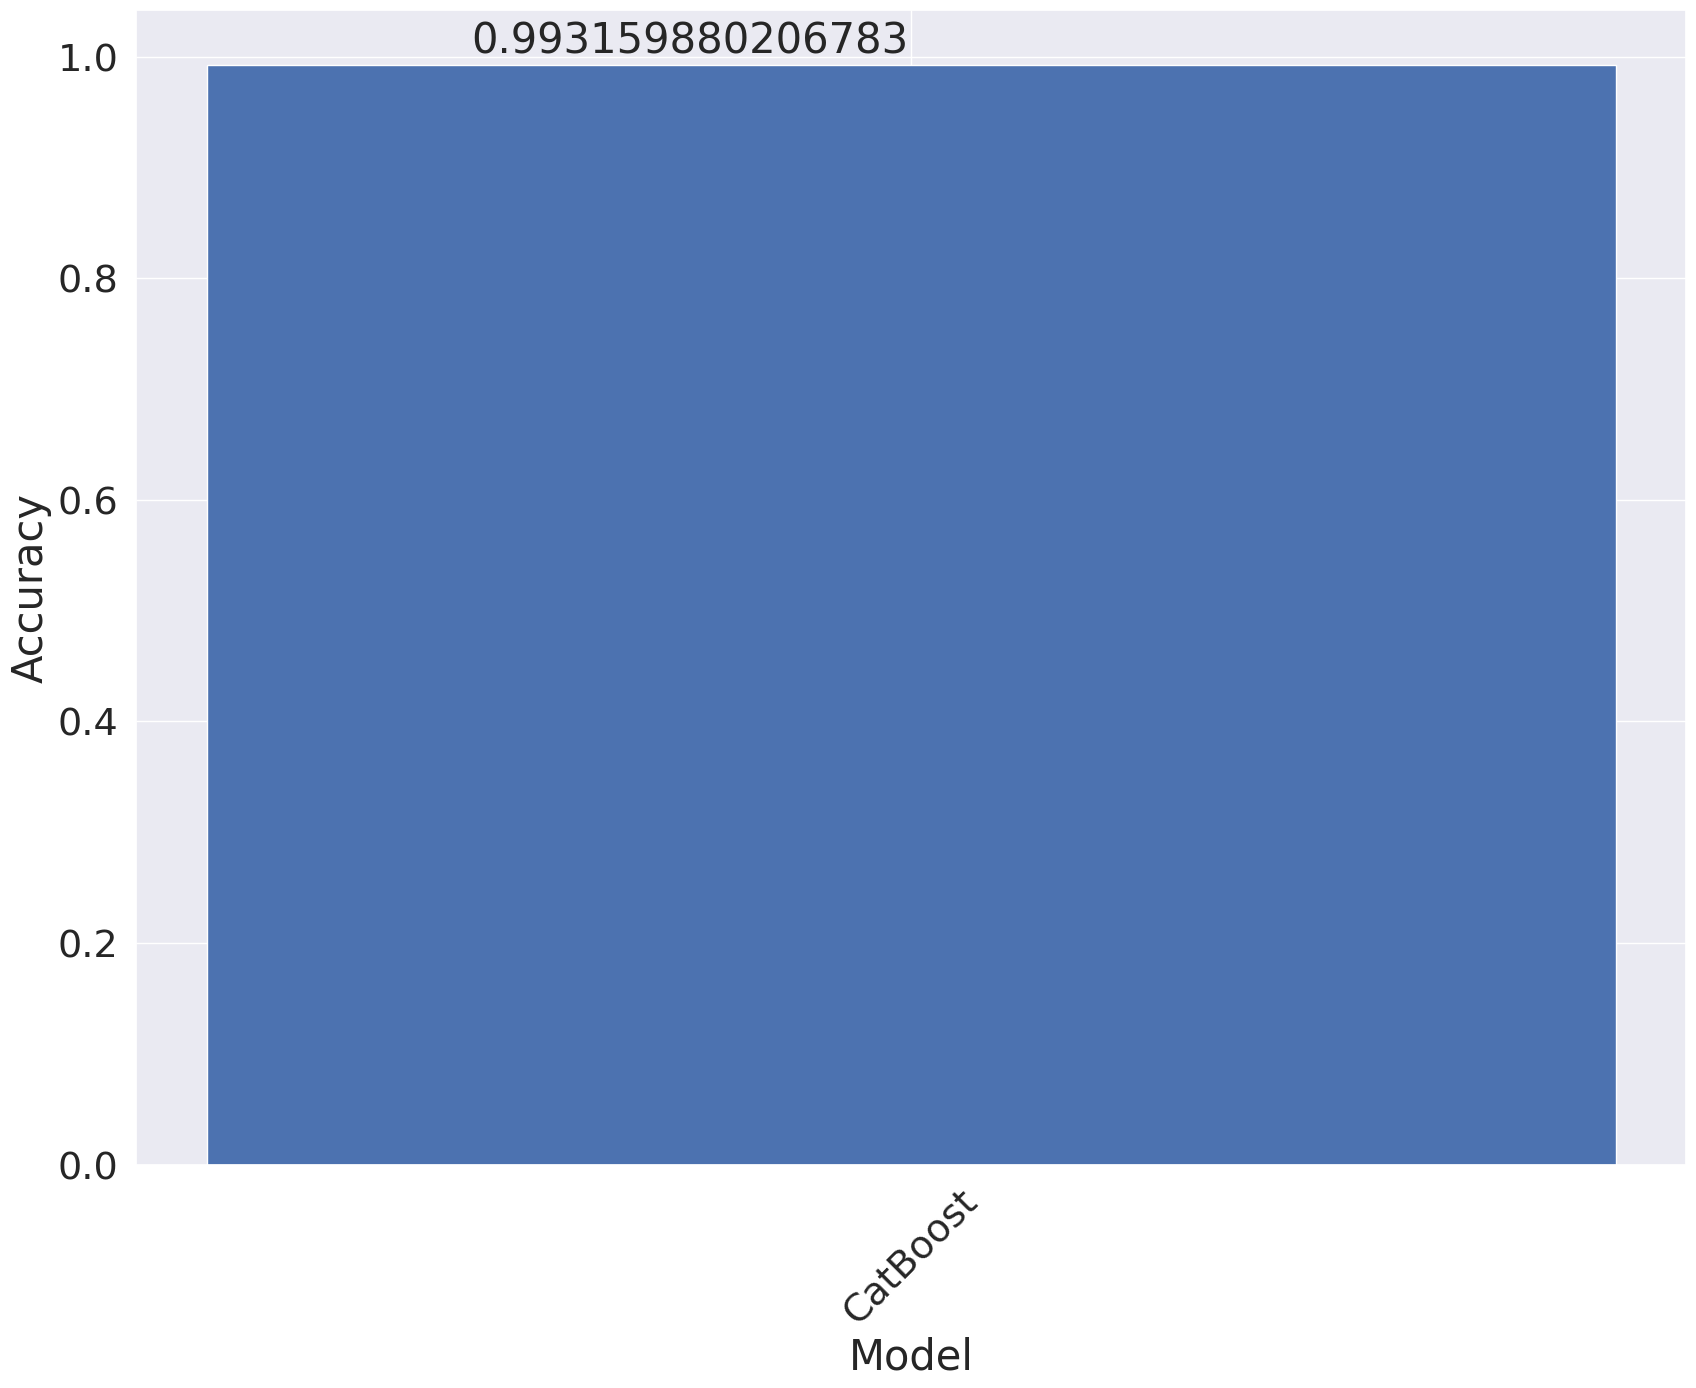

In [30]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [31]:
# test 데이터 predict 구하기
# xgb
#xgboost.predict(df_test[x_data])
# lgb
#lgb.predict(df_test[x_data])
# cat
cat.predict(df_test[x_data])

array([0, 1, 1, ..., 0, 0, 1])

## Confusion matrix

In [32]:
confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for CatBoost
[[284312    305]
 [  1947  42670]]



In [33]:
y_pred = cat.predict(df_test[x_data])

cm = confusion_matrix(df_test['target'], y_pred)
# 딕셔너리에 저장
confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()




Confusion Matrix for CatBoost
[[284402    303]
 [  1954  42575]]



## Shap 추가
출처 : https://todayisbetterthanyesterday.tistory.com/57

In [ ]:
explainer = shap.TreeExplainer(cat) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
#shap.force_plot(explainer.expected_value, shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)